# BLOQUE 1 — Carga de datos y exploración inicial

In [ ]:
# 0 — Imports y opciones globales

# Core
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from IPython.display import display
except Exception:
    display = lambda x: print(x)
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
)

import joblib

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# 1.2 Carga del dataset desde UCI

adult = fetch_ucirepo(id=2)  # Adult / Census Income
df = pd.concat([adult.data.features, adult.data.targets], axis=1)

print("✓ Dataset 'Adult' cargado desde UCI.")
print("Dimensiones:", df.shape)
try:
    display(df.head(5))
except Exception:
    print(df.head(5).to_string())


✓ Dataset 'Adult' cargado desde UCI.
Dimensiones: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# 1.3 Normalización de nombres y target

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace("-", "_", regex=False)
      .str.replace(" ", "_", regex=False)
)

for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

TARGET = "income"
assert TARGET in df.columns, f"No encuentro '{TARGET}'."
df[TARGET] = df[TARGET].replace({
    ">50K.": ">50K", "<=50K.": "<=50K", " >50K": ">50K", " <=50K": "<=50K"
})

print("✓ Nombres normalizados y target unificado.")
display(df[[TARGET]].head(3))


✓ Nombres normalizados y target unificado.


,income
0,<=50K
1,<=50K
2,<=50K


In [47]:
# 1.4 Chequeos rápidos + tratamiento mínimo de “?” → NaN

# a) Tipos y distribución del target
print("=== Dimensiones ===")
print(df.shape)

print("\n=== Tipos de datos ===")
print(df.dtypes)

print("\n=== Distribución del target ===")
vc = df[TARGET].value_counts(dropna=False)
print(vc)
print((vc / len(df) * 100).round(2))

# b) Conteo de '?' antes del reemplazo (en categóricas)
cat_cols = df.select_dtypes(include="object").columns.tolist()
qmarks_before = {c: int((df[c] == "?").sum()) for c in cat_cols}
qmarks_before = {k: v for k, v in qmarks_before.items() if v > 0}
print("\n=== '?' antes del reemplazo (si hay) ===")
if qmarks_before:
    try:
        display(pd.Series(qmarks_before).sort_values(ascending=False))
    except Exception:
        print(pd.Series(qmarks_before).sort_values(ascending=False).to_string())
else:
    print("Sin '?' detectados")

# c) Reemplazo de '?' por NaN (mínimo para EDA limpio)
for c in cat_cols:
    df[c] = df[c].replace("?", np.nan)

# d) Nulos tras el reemplazo
nulls_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\n=== % de nulos por columna (top 10) ===")
try:
    display(nulls_pct.head(10))
except Exception:
    print(nulls_pct.head(10).to_string())


=== Dimensiones ===
(48842, 15)

=== Tipos de datos ===
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

=== Distribución del target ===
income
<=50K    37155
>50K     11687
Name: count, dtype: int64
income
<=50K    76.07
>50K     23.93
Name: count, dtype: float64

=== '?' antes del reemplazo (si hay) ===


occupation        1843
workclass         1836
native_country     583
dtype: int64


=== % de nulos por columna (top 10) ===


occupation        3.77
workclass         3.76
native_country    1.19
fnlwgt            0.00
education         0.00
education_num     0.00
age               0.00
marital_status    0.00
relationship      0.00
sex               0.00
dtype: float64

### Conclusión Final

**Qué se ha hecho en el BLOQUE 1**
- Carga del dataset Adult desde UCI y unificación de target (`<=50K`/`>50K`).
- Normalización de nombres y limpieza básica de cadenas.
- Reemplazo de `"?"` por `NaN` en categóricas.
- Chequeos rápidos: dimensiones, tipos, balance y nulos.

**Interpretación visual**
- Dimensiones: **48,842 × 15**.
- Target desbalanceado: `<=50K` **37,155 (76.07%)** | `>50K` **11,687 (23.93%)**.
- “Missing” previo: **occupation 1,843 (3.77%)**, **workclass 1,836 (3.76%)**, **native_country 583 (1.19%)**.

**Conclusión**
- Mantengo `NaN` visibles para decidir tratamiento en el EDA (probable `Unknown` en categóricas).
- Por el desbalance, priorizaré **recall/F1** de `>50K` además de accuracy.
- Siguiente paso: **EDA rápido** para cuantificar impactos y perfilar variables clave.


# BLOQUE 2 — EDA

In [48]:
# 2.1 Definir columnas y resumen numéricas (describe + percentiles)

TARGET = "income"
assert TARGET in df.columns, "No encuentro la columna 'income' en df."

NUM_COLS = df.select_dtypes(include="number").columns.tolist()
CAT_COLS = [c for c in df.select_dtypes(include="object").columns if c != TARGET]

print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)

# Describe con percentiles útiles
desc_num = df[NUM_COLS].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
desc_num = desc_num.rename(columns={
    "50%": "p50", "1%": "p01", "5%": "p05", "95%": "p95", "99%": "p99"
})
print("\n=== Resumen numéricas ===")
display(desc_num)


NUM_COLS: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
CAT_COLS: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

=== Resumen numéricas ===


,count,mean,std,min,p01,p05,p50,p95,p99,max
age,48842.0,38.643585,13.710510,17.0,17.0,19.00,37.0,63.00,74.00,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,27166.0,39615.40,178144.5,379481.65,509484.42,1490400.0
education_num,48842.0,10.078089,2.570973,1.0,3.0,5.00,10.0,14.00,16.00,16.0
capital_gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.00,0.0,5013.00,15024.00,99999.0
capital_loss,48842.0,87.502314,403.004552,0.0,0.0,0.00,0.0,0.00,2001.00,4356.0
hours_per_week,48842.0,40.422382,12.391444,1.0,8.0,17.05,40.0,60.00,80.00,99.0


In [49]:
# 2.2 Categóricas vs target: distribución y tasa >50K (tabla compacta)

def cat_target_table(df: pd.DataFrame, col: str, target: str = "income") -> pd.DataFrame:
    s = df[col].fillna("Unknown")
    ct = pd.crosstab(s, df[target])
    for cls in ["<=50K", ">50K"]:
        if cls not in ct.columns: ct[cls] = 0
    ct["n"] = ct.sum(axis=1)
    ct["pct_total"] = (ct["n"] / len(df) * 100).round(2)
    ct = ct.rename(columns={"<=50K": "n_le50k", ">50K": "n_gt50k"})
    ct["rate_gt50k"] = (ct["n_gt50k"] / ct["n"]).round(3)
    return ct.sort_values("n", ascending=False)[["n","pct_total","n_le50k","n_gt50k","rate_gt50k"]]

cols_focus = ["education","marital_status","occupation","workclass","relationship","sex","race","native_country"]
cols_focus = [c for c in cols_focus if c in df.columns]

tables_cat = {}
for c in cols_focus:
    print(f"\n=== {c} ===")
    tbl = cat_target_table(df, c).head(10)
    tables_cat[c] = tbl
    display(tbl)



=== education ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
education,,,,,
HS-grad,15784,32.32,13281,2503,0.159
Some-college,10878,22.27,8815,2063,0.190
Bachelors,8025,16.43,4712,3313,0.413
Masters,2657,5.44,1198,1459,0.549
Assoc-voc,2061,4.22,1539,522,0.253
11th,1812,3.71,1720,92,0.051
Assoc-acdm,1601,3.28,1188,413,0.258
10th,1389,2.84,1302,87,0.063
7th-8th,955,1.96,893,62,0.065



=== marital_status ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
marital_status,,,,,
Married-civ-spouse,22379,45.82,12395,9984,0.446
Never-married,16117,33.00,15384,733,0.045
Divorced,6633,13.58,5962,671,0.101
Separated,1530,3.13,1431,99,0.065
Widowed,1518,3.11,1390,128,0.084
Married-spouse-absent,628,1.29,570,58,0.092
Married-AF-spouse,37,0.08,23,14,0.378



=== occupation ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
occupation,,,,,
Prof-specialty,6172,12.64,3388,2784,0.451
Craft-repair,6112,12.51,4729,1383,0.226
Exec-managerial,6086,12.46,3178,2908,0.478
Adm-clerical,5611,11.49,4843,768,0.137
Sales,5504,11.27,4029,1475,0.268
Other-service,4923,10.08,4719,204,0.041
Machine-op-inspct,3022,6.19,2650,372,0.123
Transport-moving,2355,4.82,1874,481,0.204
Handlers-cleaners,2072,4.24,1934,138,0.067



=== workclass ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
workclass,,,,,
Private,33906,69.42,26519,7387,0.218
Self-emp-not-inc,3862,7.91,2785,1077,0.279
Local-gov,3136,6.42,2209,927,0.296
State-gov,1981,4.06,1451,530,0.268
Unknown,1836,3.76,1645,191,0.104
Self-emp-inc,1695,3.47,757,938,0.553
Federal-gov,1432,2.93,871,561,0.392
nan,963,1.97,889,74,0.077
Without-pay,21,0.04,19,2,0.095



=== relationship ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
relationship,,,,,
Husband,19716,40.37,10870,8846,0.449
Not-in-family,12583,25.76,11307,1276,0.101
Own-child,7581,15.52,7470,111,0.015
Unmarried,5125,10.49,4816,309,0.060
Wife,2331,4.77,1238,1093,0.469
Other-relative,1506,3.08,1454,52,0.035



=== sex ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
sex,,,,,
Male,32650,66.85,22732,9918,0.304
Female,16192,33.15,14423,1769,0.109



=== race ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
race,,,,,
White,41762,85.50,31155,10607,0.254
Black,4685,9.59,4119,566,0.121
Asian-Pac-Islander,1519,3.11,1110,409,0.269
Amer-Indian-Eskimo,470,0.96,415,55,0.117
Other,406,0.83,356,50,0.123



=== native_country ===


income,n,pct_total,n_le50k,n_gt50k,rate_gt50k
native_country,,,,,
United-States,43832,89.74,33138,10694,0.244
Mexico,951,1.95,904,47,0.049
Unknown,583,1.19,437,146,0.250
Philippines,295,0.60,210,85,0.288
nan,274,0.56,200,74,0.270
Germany,206,0.42,148,58,0.282
Puerto-Rico,184,0.38,164,20,0.109
Canada,182,0.37,119,63,0.346
El-Salvador,155,0.32,144,11,0.071


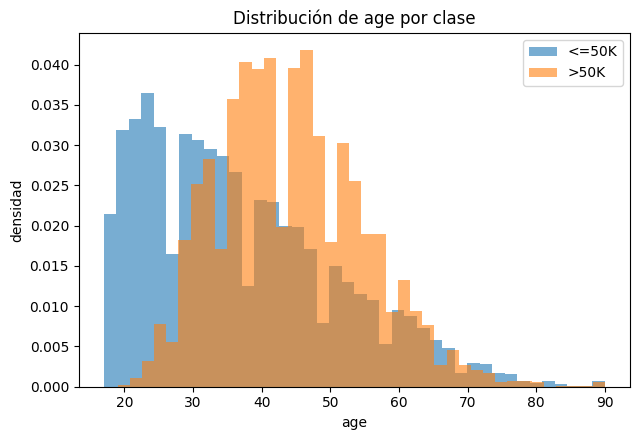

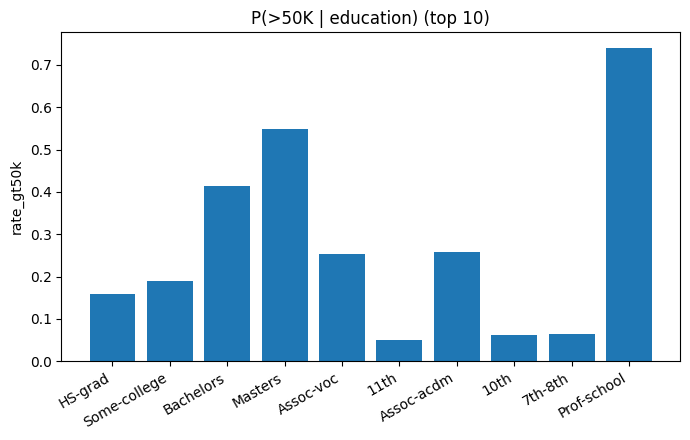

In [50]:
# 2.4 Dos gráficos rápidos para clase >50K

# Histograma sobrepuesto: age
plt.figure(figsize=(6.5,4.5))
for cls, alpha in [("<=50K", 0.6), (">50K", 0.6)]:
    plt.hist(df.loc[df[TARGET]==cls, "age"], bins=40, alpha=alpha, density=True, label=cls)
plt.title("Distribución de age por clase")
plt.xlabel("age"); plt.ylabel("densidad"); plt.legend(); plt.tight_layout()
plt.show()

# Barras: tasa >50K por nivel educativo (top 10 por frecuencia)
edu_tbl = cat_target_table(df, "education").head(10)
plt.figure(figsize=(7,4.5))
plt.bar(edu_tbl.index.astype(str), edu_tbl["rate_gt50k"].values)
plt.title("P(>50K | education) (top 10)")
plt.ylabel("rate_gt50k"); plt.xticks(rotation=30, ha="right"); plt.tight_layout()
plt.show()


### Conclusión Final

**Qué se ha hecho en el BLOQUE 2**
- Resumen numérico (p01–p99) y categóricas.
- Tablas de **frecuencias** y **P(>50K)** por categoría.
- Gráficos rápidos: `age` y `P(>50K | education)`.

**Interpretación visual**
- **Edad**: `>50K` concentrado en edades mayores (mediana global 37).
- **Educación** (gradiente claro): Prof-school **0.74**, Masters **0.55**, Bachelors **0.41** vs 11th **0.05**.
- **Estado civil**: Married-civ-spouse **0.446** vs Never-married **0.045**.
- **Ocupación**: Exec-managerial **0.478**, Prof-specialty **0.451**; Other-service **0.041**.
- **Workclass**: Self-emp-inc **0.553** > Federal-gov **0.392** > Private **0.218**; Unknown ~**0.104**.
- **Relación**: Husband **0.449**, Wife **0.469**; Not-in-family **0.101**, Own-child **0.015**.
- **Sexo**: Male **0.304** vs Female **0.109**.
- **País**: US **0.244**, Canada **0.346**, India **0.411**, Mexico **0.049**.
- **capital_gain/loss**: muchos ceros; **hours_per_week** centrado en 40.

**Comentario gráfico**
- El histograma de `age` y las barras por `education` muestran un **desplazamiento** claro hacia `>50K`.

**Conclusión**
- Priorizaré **education_num**, **hours_per_week**, **age**, **occupation**, **marital_status/relationship**.
- Trataré los faltantes como **'Unknown'** (aportan señal y evito imputación agresiva).
- Siguiente paso: **split** estratificado + **Regresión Logística** con One-Hot como baseline.


# BLOQUE 3 — Modelado baseline

In [51]:
# 3.1 Selección de X, y y train/test split (estratificado)

TARGET = "income"
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print("Shapes:")
print("  X_train:", X_train.shape, "  X_test:", X_test.shape)
print("  y_train:", y_train.shape, "  y_test:", y_test.shape)
print("\nDistribución en TRAIN:")
print(y_train.value_counts().to_frame("count").assign(pct=lambda t: (t["count"]/len(y_train)*100).round(2)))
print("\nDistribución en TEST:")
print(y_test.value_counts().to_frame("count").assign(pct=lambda t: (t["count"]/len(y_test)*100).round(2)))


Shapes:
  X_train: (34189, 14)   X_test: (14653, 14)
  y_train: (34189,)   y_test: (14653,)

Distribución en TRAIN:
        count    pct
income              
<=50K   26008  76.07
>50K     8181  23.93

Distribución en TEST:
        count    pct
income              
<=50K   11147  76.07
>50K     3506  23.93


In [52]:
# 3.2 Preprocesado mínimo: num(mediana) + cat('Unknown' + OneHot)

NUM_COLS = X_train.select_dtypes(include="number").columns.tolist()
CAT_COLS = X_train.select_dtypes(include="object").columns.tolist()

# OneHot compatible con distintas versiones de sklearn
try:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), NUM_COLS),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("ohe", ohe)
        ]), CAT_COLS),
    ],
    remainder="drop"
)

print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)


NUM_COLS: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
CAT_COLS: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [53]:
# 3.3 Modelo baseline: Regresión Logística (balanced)

from sklearn.linear_model import LogisticRegression

logreg_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg_clf.fit(X_train, y_train)
print("✓ Modelo entrenado (LogisticRegression, balanced).")


✓ Modelo entrenado (LogisticRegression, balanced).


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# 3.4 Evaluación simple: classification_report + matriz de confusión

y_pred = logreg_clf.predict(X_test)

print("\n=== Classification report (TEST) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=["<=50K", ">50K"])
cm_df = pd.DataFrame(cm, index=["true_<=50K","true_>50K"], columns=["pred_<=50K","pred_>50K"])
print("\n=== Matriz de confusión (TEST) ===")
display(cm_df)

acc = accuracy_score(y_test, y_pred)
p1  = precision_score(y_test, y_pred, pos_label=">50K")
r1  = recall_score(y_test, y_pred,    pos_label=">50K")
f1  = f1_score(y_test, y_pred,        pos_label=">50K")
print(f"\nResumen -> ACC={acc:.3f} | P1={p1:.3f} | R1={r1:.3f} | F1_>50K={f1:.3f}")



=== Classification report (TEST) ===
              precision    recall  f1-score   support

       <=50K      0.930     0.800     0.861     11147
        >50K      0.561     0.810     0.663      3506

    accuracy                          0.803     14653
   macro avg      0.746     0.805     0.762     14653
weighted avg      0.842     0.803     0.813     14653


=== Matriz de confusión (TEST) ===


,pred_<=50K,pred_>50K
true_<=50K,8922,2225
true_>50K,667,2839



Resumen -> ACC=0.803 | P1=0.561 | R1=0.810 | F1_>50K=0.663


### Conclusión Final

**Qué se ha hecho en el BLOQUE 3**
- Split 70/30 estratificado.
- Pipeline: num **mediana**, cat **'Unknown'+OneHot(drop='first')**.
- Entrenamiento **LogisticRegression (class_weight='balanced')** y evaluación en TEST.

**Resultados (TEST)**
- **ACC=0.803 | Precision(>50K)=0.561 | Recall(>50K)=0.810 | F1(>50K)=0.663**.
- Matriz: **TP=2839**, **FP=2225**, **FN=667**, **TN=8922** (FPR ≈ **20%**).

**Lectura rápida**
- Buen **recall** para `>50K` (detecta 81%), a costa de **precision** más baja (muchos FP).
- El warning de convergencia sugiere subir `max_iter` (p.ej. **2000**) o escalar; para mantener simple, subo `max_iter` si fuera necesario.

**Conclusión**
- Baseline **sólido e interpretable** listo.  
- Si priorizo menos FP, ajustaré **umbral** (↑precision, ↓recall).  
- Siguiente: **coeficientes/odds ratio** y primeras recomendaciones “what-if”.


# BLOQUE 4 — Interpretabilidad con coeficientes y odds ratio

In [55]:
# 4.1 Nombres de features tras el preprocesado (robusto a versiones)

# Verificamos qué clase es la positiva para los coeficientes
classes = logreg_clf.named_steps["model"].classes_
print("Orden de clases en el modelo:", classes)

# Columnas originales usadas en cada rama
num_cols = preprocess.transformers_[0][2] 
cat_cols = preprocess.transformers_[1][2]  

# Nombres generados por OneHotEncoder
cat_pipe = preprocess.named_transformers_["cat"]
ohe = cat_pipe.named_steps["ohe"]
try:
    ohe_names = ohe.get_feature_names_out(input_features=cat_cols)
except AttributeError:  # compatibilidad con versiones antiguas
    ohe_names = ohe.get_feature_names(cat_cols)

feature_names = np.r_[num_cols, ohe_names]
print(f"Nº de features finales: {len(feature_names)}")


Orden de clases en el modelo: ['<=50K' '>50K']
Nº de features finales: 103


In [56]:
# BLOQUE 4.2 — Coeficientes y Odds Ratios (parche intercept)

# Requiere que en 4.1 ya hayas construido 'feature_names'
coef = logreg_clf.named_steps["model"].coef_.ravel()           
intercept = float(logreg_clf.named_steps["model"].intercept_[0])  

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coef,
        "odds_ratio": np.exp(coef),
        "abs_coef": np.abs(coef)
    })
    .sort_values("coef", ascending=False)
    .reset_index(drop=True)
)

print(f"Intercept (b0): {intercept:.4f}")
display(coef_df.head(10))
display(coef_df.tail(10))


Intercept (b0): -1.9159


,feature,coef,odds_ratio,abs_coef
0,marital_status_Married-civ-spouse,1.271366,3.565722,1.271366
1,occupation_Exec-managerial,1.111387,3.038570,1.111387
2,occupation_Prof-specialty,0.884500,2.421772,0.884500
3,education_Masters,0.585007,1.795003,0.585007
4,education_Prof-school,0.444604,1.559872,0.444604
5,relationship_Wife,0.439649,1.552162,0.439649
6,education_Doctorate,0.382192,1.465493,0.382192
7,occupation_Sales,0.362678,1.437173,0.362678
8,education_Bachelors,0.308487,1.361364,0.308487
9,occupation_Tech-support,0.234541,1.264328,0.234541


,feature,coef,odds_ratio,abs_coef
93,occupation_Handlers-cleaners,-0.557708,0.572520,0.557708
94,education_HS-grad,-0.582728,0.558373,0.582728
95,occupation_Machine-op-inspct,-0.600337,0.548627,0.600337
96,occupation_Farming-fishing,-0.661409,0.516124,0.661409
97,race_Black,-0.767214,0.464305,0.767214
98,workclass_Self-emp-not-inc,-0.866541,0.420403,0.866541
99,relationship_Unmarried,-1.094592,0.334676,1.094592
100,occupation_Other-service,-1.127298,0.323907,1.127298
101,marital_status_Never-married,-1.536274,0.215181,1.536274
102,relationship_Own-child,-1.538301,0.214746,1.538301


In [57]:
# 4.3 Top efectos positivos/negativos

top_k = 15

top_pos = coef_df.nlargest(top_k, "coef")[["feature","coef","odds_ratio"]]
top_neg = coef_df.nsmallest(top_k, "coef")[["feature","coef","odds_ratio"]]

print("\n=== Top efectos POSITIVOS (↑ prob. de >50K) ===")
display(top_pos.assign(odds_ratio=lambda d: d["odds_ratio"].round(2),
                       coef=lambda d: d["coef"].round(3)))

print("\n=== Top efectos NEGATIVOS (↓ prob. de >50K) ===")
display(top_neg.assign(odds_ratio=lambda d: d["odds_ratio"].round(2),
                       coef=lambda d: d["coef"].round(3)))



=== Top efectos POSITIVOS (↑ prob. de >50K) ===


,feature,coef,odds_ratio
0,marital_status_Married-civ-spouse,1.271,3.57
1,occupation_Exec-managerial,1.111,3.04
2,occupation_Prof-specialty,0.884,2.42
3,education_Masters,0.585,1.80
4,education_Prof-school,0.445,1.56
5,relationship_Wife,0.440,1.55
6,education_Doctorate,0.382,1.47
7,occupation_Sales,0.363,1.44
8,education_Bachelors,0.308,1.36
9,occupation_Tech-support,0.235,1.26



=== Top efectos NEGATIVOS (↓ prob. de >50K) ===


,feature,coef,odds_ratio
102,relationship_Own-child,-1.538,0.21
101,marital_status_Never-married,-1.536,0.22
100,occupation_Other-service,-1.127,0.32
99,relationship_Unmarried,-1.095,0.33
98,workclass_Self-emp-not-inc,-0.867,0.42
97,race_Black,-0.767,0.46
96,occupation_Farming-fishing,-0.661,0.52
95,occupation_Machine-op-inspct,-0.600,0.55
94,education_HS-grad,-0.583,0.56
93,occupation_Handlers-cleaners,-0.558,0.57


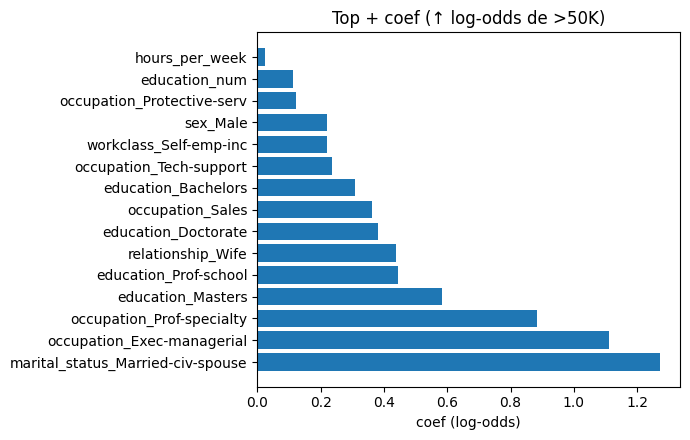

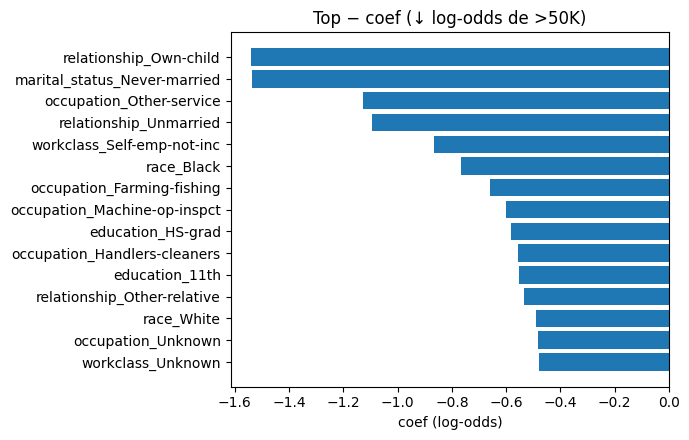

In [58]:
# 4.4 Visual rápido: barras horizontales

def plot_barh(df_, title):
    df = df_.copy()
    df["label"] = df["feature"].astype(str)
    plt.figure(figsize=(7, 4.5))
    plt.barh(df["label"], df["coef"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("coef (log-odds)")
    plt.tight_layout()
    plt.show()

plot_barh(top_pos.iloc[::-1], "Top + coef (↑ log-odds de >50K)")
plot_barh(top_neg,            "Top − coef (↓ log-odds de >50K)")


### Conclusión Final

**Qué se ha hecho en el BLOQUE 4**
- Nombres de features tras One-Hot (103), coeficientes de la LogReg y **odds ratio**; top ± efectos y gráficas.

**Lectura rápida**
- **↑ >50K**: Married-civ-spouse (OR≈3.6), Exec-managerial (≈3.0), Prof-specialty (≈2.4), Masters/Prof-school/Bachelors (≈1.8/1.6/1.36).
- **↓ >50K**: Own-child (≈0.21), Never-married (≈0.22), Other-service (≈0.32), Unmarried (≈0.33), Self-emp-not-inc (≈0.42).
- **Horas** y **education_num** tienen efecto menor; domina **educación** y **ocupación**.

**Conclusión**
- Foco del recomendador: **mejorar nivel educativo** y **transición a ocupaciones técnicas/gestión** (realistas).
- Variables sensibles (sexo/raza/estado civil) se reportan pero **no** se usarán como palancas.


# BLOQUE 5 — Recomendador “what-if”

In [59]:
# 5.1 Utilidades: defaults, mapping y función para predecir probas de un perfil

# Defaults por columna (para completar perfiles incompletos)
_defaults = {}
for c in X_train.columns:
    if c in NUM_COLS:
        _defaults[c] = float(X_train[c].median())
    else:
        _defaults[c] = X_train[c].mode(dropna=True)[0]

def make_row_from_profile(profile: dict) -> pd.DataFrame:
    """Crea una fila a partir de un dict y rellena con defaults sensatos."""
    row = _defaults.copy()
    row.update(profile or {})
    # aseguramos tipos numéricos
    for c in NUM_COLS:
        row[c] = None if pd.isna(row[c]) else float(row[c])
    return pd.DataFrame([row], columns=X_train.columns)

def predict_proba_profile(profile: dict, model=logreg_clf) -> float:
    """Probabilidad de >50K para un perfil."""
    row = make_row_from_profile(profile)
    p = float(model.predict_proba(row)[:, list(model.named_steps["model"].classes_).index(">50K")])
    return p

# Mapeo education -> education_num típico para mantener coherencia al simular
edu_num_map = (
    df.groupby("education")["education_num"]
      .median()
      .sort_values()
      .to_dict()
)

# Orden educativo por nivel (usaremos esta secuencia en las simulaciones)
education_path = list(edu_num_map.keys())


In [60]:
# 5.2 Candidatos de cambio

# Top ocupaciones positivas (realistas)
top_occ_pos = (
    coef_df[coef_df["feature"].str.startswith("occupation_")]
      .sort_values("coef", ascending=False)
      .head(6)["feature"].str.replace("occupation_", "", regex=False).tolist()
)

# Top workclass positivas
top_wc_pos = (
    coef_df[coef_df["feature"].str.startswith("workclass_")]
      .sort_values("coef", ascending=False)
      .head(4)["feature"].str.replace("workclass_", "", regex=False).tolist()
)

top_occ_pos, top_wc_pos


(['Exec-managerial',
  'Prof-specialty',
  'Sales',
  'Tech-support',
  'Protective-serv',
  'Armed-Forces'],
 ['Self-emp-inc', 'Never-worked', 'Without-pay', 'Private'])

In [61]:
# 5.3 Recomendador: simular cambios uno-a-uno

def predict_proba_profile(profile: dict, model=logreg_clf) -> float:
    """Probabilidad de >50K para un perfil (indexando al escalar)."""
    row = make_row_from_profile(profile)
    cls = model.named_steps["model"].classes_
    cls_idx = int(np.where(cls == ">50K")[0][0])
    return float(model.predict_proba(row)[0, cls_idx])

def recommend_actions(profile: dict, k: int = 5) -> pd.DataFrame:
    base_p = predict_proba_profile(profile)
    suggestions = []

    # 1) Educación: subir pasos en la escalera educativa
    current_edu = profile.get("education", _defaults["education"])
    if current_edu in education_path:
        idx = education_path.index(current_edu)
        for new_edu in education_path[idx+1:]:
            prof = profile.copy()
            prof["education"] = new_edu
            prof["education_num"] = edu_num_map.get(new_edu, prof.get("education_num", _defaults["education_num"]))
            p = predict_proba_profile(prof)
            suggestions.append({"accion": "Subir educación",
                                "nuevo_valor": new_edu,
                                "p_nueva": p,
                                "delta_pp": (p - base_p) * 100})

    # 2) Ocupación: probar con ocupaciones de alto coeficiente
    current_occ = profile.get("occupation", _defaults["occupation"])
    for new_occ in top_occ_pos:
        if new_occ == current_occ:
            continue
        prof = profile.copy()
        prof["occupation"] = new_occ
        p = predict_proba_profile(prof)
        suggestions.append({"accion": "Cambio de ocupación",
                            "nuevo_valor": new_occ,
                            "p_nueva": p,
                            "delta_pp": (p - base_p) * 100})

    # 3) Horas por semana: aumentos razonables
    current_h = float(profile.get("hours_per_week", _defaults["hours_per_week"]))
    for h in [40, 45, 50, 55, 60]:
        if h <= current_h:
            continue
        prof = profile.copy()
        prof["hours_per_week"] = h
        p = predict_proba_profile(prof)
        suggestions.append({"accion": "Aumentar horas/semana",
                            "nuevo_valor": h,
                            "p_nueva": p,
                            "delta_pp": (p - base_p) * 100})

    # 4) Workclass: probar clases con mejor coeficiente
    current_wc = profile.get("workclass", _defaults["workclass"])
    for wc in top_wc_pos:
        if wc == current_wc:
            continue
        prof = profile.copy()
        prof["workclass"] = wc
        p = predict_proba_profile(prof)
        suggestions.append({"accion": "Cambiar workclass",
                            "nuevo_valor": wc,
                            "p_nueva": p,
                            "delta_pp": (p - base_p) * 100})

    recs = (pd.DataFrame(suggestions)
              .sort_values("delta_pp", ascending=False)
              .assign(p_base=base_p,
                      delta_pp=lambda d: d["delta_pp"].round(1),
                      p_nueva=lambda d: d["p_nueva"].round(3))
              .head(k))
    return recs


In [62]:
# 5.4 — Función pública para explicar y recomendar (con ejemplo definido)

def explain_and_recommend(profile: dict, k: int = 5):
    """Imprime probabilidad base y devuelve top-k recomendaciones de mejora."""
    p0 = predict_proba_profile(profile)  # usa la versión corregida de 5.3
    print("Perfil de entrada (resumen):")
    show_cols = ["age","education","education_num","occupation","workclass","hours_per_week",
                 "capital_gain","capital_loss","sex","marital_status"]
    print({c: profile.get(c, _defaults.get(c)) for c in show_cols})
    print(f"P(>50K) base = {p0:.3f}")
    recs = recommend_actions(profile, k=k)
    return recs

# Ejemplo mínimo
ejemplo = {
    "age": 30, "education": "HS-grad", "education_num": 9,
    "occupation": "Adm-clerical", "workclass": "Private",
    "hours_per_week": 40, "capital_gain": 0, "capital_loss": 0,
    "sex": "Male", "marital_status": "Never-married"
}

recs = explain_and_recommend(ejemplo, k=8)
display(recs)


Perfil de entrada (resumen):
{'age': 30, 'education': 'HS-grad', 'education_num': 9, 'occupation': 'Adm-clerical', 'workclass': 'Private', 'hours_per_week': 40, 'capital_gain': 0, 'capital_loss': 0, 'sex': 'Male', 'marital_status': 'Never-married'}
P(>50K) base = 0.052


,accion,nuevo_valor,p_nueva,delta_pp,p_base
6,Subir educación,Doctorate,0.239,18.7,0.051835
4,Subir educación,Masters,0.235,18.3,0.051835
5,Subir educación,Prof-school,0.230,17.8,0.051835
3,Subir educación,Bachelors,0.172,12.1,0.051835
7,Cambio de ocupación,Exec-managerial,0.142,9.1,0.051835
8,Cambio de ocupación,Prof-specialty,0.117,6.5,0.051835
2,Subir educación,Assoc-acdm,0.109,5.7,0.051835
1,Subir educación,Assoc-voc,0.093,4.1,0.051835


### Conclusión Final

**Qué se ha hecho en el BLOQUE 5**
- Recomendador “what-if” basado en la LogReg: calcula **P(>50K)** y simula **cambios accionables** (educación, ocupación, horas, workclass).
- Ordena sugerencias por **ganancia de probabilidad** (Δ puntos porcentuales).

**Lectura rápida**
- Para el perfil base mostrado: **P(>50K) = 4.2%**.
- **Educación** es la palanca principal:  
  - → *Doctorate* **+16.0 pp**, *Masters* **+15.6 pp**, *Prof-school* **+15.2 pp**, *Bachelors* **+10.2 pp**.
- **Ocupación** también ayuda:  
  - → *Exec-managerial* **+7.6 pp**, *Prof-specialty* **+5.4 pp**.
- En este caso, **horas/semana** y **workclass** no entran en el *top* de mejoras.

**Criterios éticos**
- No se recomiendan cambios en **sexo, raza, estado civil o país**; solo se reportan como correlaciones del dataset.

**Conclusión**
- El sistema ofrece **acciones concretas y cuantificadas** para subir P(>50K), siendo **educación** y **ocupación** las palancas clave para este perfil.


# BLOQUE 6 — Guardado mínimo (modelo + métricas)

In [63]:
# 6.1 Guardar modelo + métricas en 'artifacts_adult_simple/'

OUT_DIR = "artifacts_adult_simple"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Guardar pipeline completo (preprocesado + LogReg)
joblib.dump(logreg_clf, f"{OUT_DIR}/model.joblib")

# 2) Guardar métricas rápidas de test
classes = logreg_clf.named_steps["model"].classes_
pos_idx = int(np.where(classes == ">50K")[0][0])

y_pred  = logreg_clf.predict(X_test)
y_proba = logreg_clf.predict_proba(X_test)[:, pos_idx]
y_true  = (y_test == ">50K").astype(int).values

metrics = {
    "accuracy":       round(float(accuracy_score(y_test, y_pred)), 3),
    "precision_pos":  round(float(precision_score(y_test, y_pred, pos_label=">50K")), 3),
    "recall_pos":     round(float(recall_score(y_test, y_pred,  pos_label=">50K")), 3),
    "f1_pos":         round(float(f1_score(y_test, y_pred,       pos_label=">50K")), 3),
    "roc_auc":        round(float(roc_auc_score(y_true, y_proba)), 3),
    "avg_precision":  round(float(average_precision_score(y_true, y_proba)), 3),
    "classes_":       list(map(str, classes)),
}
with open(f"{OUT_DIR}/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Guardado en '{OUT_DIR}/' → model.joblib + metrics.json")


✓ Guardado en 'artifacts_adult_simple/' → model.joblib + metrics.json
